In [4]:
import numpy as np
#import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
import re
import time
#from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# from boruta import BorutaPy

from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
#from sdv.evaluation import evaluate

import warnings
warnings.filterwarnings("ignore")

In [6]:
def preprocess_data(df):
#     df = pd.read_csv(path_csv)
    # dropping the rows having NaN values
    df.dropna(inplace=True)

    # To reset the indices
    df.reset_index(drop=True, inplace=True)

    # convert category to numeric representation
    l = df.select_dtypes(include=['object']).columns.tolist()
    for col in l[:2]:
        dummies = pd.get_dummies(df[col], dtype=np.float64)
        # Concatenate the dummies to original dataframe
        df = pd.concat([df, dummies], axis='columns')
        # drop the values
        df.drop([col], axis='columns', inplace=True)

    #collect numeric data
    data_numeric = df.select_dtypes(include=['float64', 'int64'])

    return data_numeric

In [7]:
df=pd.read_csv("final_balanced_water_dataset.csv")

In [8]:
df_sample = df.sample(n=300000)

In [9]:
df.shape

(1458716, 25)

In [10]:
df_preprocessed = preprocess_data(df_sample)
df['Target'].value_counts()

Target
0.0    824946
1.0    633769
Name: count, dtype: int64

In [11]:
def train_test (df):
    Y=df['Target']
    X=df.drop('Target', axis=1)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X=X_scaled
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test=train_test(df_preprocessed)

In [10]:
from sklearn import metrics
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input
    if(model==lgbm):
        model.fit(X_train,y_train,eval_metric='f1')
        print('lgbm')
        
       
    model.fit(X_train, y_train)   # fit the model using the train data
    pred = model.predict(X_test)     # model predictions on the test data
    score = round(model.score(X_test, y_test), 3)   # accuracy on the test data

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()  # confusion matrix for y_test and pred_test

    recall = round(tp/(tp+fn), 3)     # calculate recall
    precision = round(tp/(tp+fp), 3)  # calculate precision
    specificity =round(tn/(tn+fp),3)  # calculate specificity
    f1_score =  round(2*precision*recall/(precision + recall), 3)   # calculate f1 score
    
    return score, recall, precision, specificity, f1_score  # return all the metrics

## pyDeepInsight


In [ ]:
df_num_sample_x=df.drop('Target',axis=1)
df_num_sample_y=df['Target']

In [ ]:
def convert_data_to_image(df_num_sample_x, df_num_sample_y, plot_pixels=False):
  #df_num_sample_x =  df.iloc[:,:-1]
  #df_num_sample_y =  df.iloc[:,-1:]
  #df_num_sample_x.drop(['Index'], axis='columns', inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(
    df_num_sample_x, df_num_sample_y, test_size=0.2, stratify=df_num_sample_y)

  ln = Norm2Scaler()
  X_train_norm = ln.fit_transform(X_train)
  X_test_norm = ln.transform(X_test)

  distance_metric = 'cosine'
  reducer = TSNE(
      n_components=2,
      metric=distance_metric,
      init='random',
      learning_rate='auto',
      n_jobs=-1,
      perplexity=5
  )

  pixel_size = (24,24)
  it = ImageTransformer(
      feature_extractor=reducer,
      pixels=pixel_size)

  it.fit(X_train, y=y_train, plot=True)
  X_train_img = it.transform(X_train_norm)
  X_test_img = it.transform(X_test_norm)

  if plot_pixels:
    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan

    plt.figure(figsize=(10, 7.5))

    ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.,
                    linecolor="lightgrey", square=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    _ = plt.title("features per pixel")


  return X_train_img, y_train, X_test_img, y_test

In [ ]:
def image_classification(model, X_train_img, y_train, X_test_img, y_test, img_preprocessor=None, epochs=120):

  if not img_preprocessor:
    img_preprocessor = transforms.Compose([
      transforms.ToTensor()
      ])

  y_train = np.reshape(y_train.values, (-1))
  y_test = np.reshape(y_test.values, (-1))

  X_train_tensor = torch.stack([img_preprocessor(img) for img in X_train_img]).float()
  y_train_tensor = torch.from_numpy(y_train)

  X_test_tensor = torch.stack([img_preprocessor(img) for img in X_test_img]).float()
  y_test_tensor = torch.from_numpy(y_test)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  batch_size = 16

  trainset = TensorDataset(X_train_tensor, y_train_tensor)
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

  testset = TensorDataset(X_test_tensor, y_test_tensor)
  testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(
      model.parameters(),
      lr=3e-4,
      #momentum=0.8,
      weight_decay=1e-05
  )

  model.train()
  model.to(device)
  for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # print(outputs, labels)

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      # print epoch statistics
      if not (epoch % 20):
          print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
  print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

  model.to('cpu')
  model = model.eval()

  with torch.no_grad():
    y_hat_train = model(X_train_tensor)
    y_hat_test = model(X_test_tensor)
  train_predicted = torch.max(y_hat_train, 1)[1]
  test_predicted = torch.max(y_hat_test, 1)[1]

  # print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
  # print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")
  # _ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=["Not Portable", "Portable"])
  print(classification_report(y_test_tensor, test_predicted, target_names=["Not Portable", "Portable"]))

In [ ]:
convert_data_to_image(df_num_sample_x, df_num_sample_y, plot_pixels=False)

In [ ]:
image_classification(model, X_train_img, y_train, X_test_img, y_test, img_preprocessor=None, epochs=120)

## stacking model

In [ ]:
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
result = pd.DataFrame(columns = ['score,', 'recall,', 'precision,', 'specificity,', 'f1_score'])

log = LogisticRegression(solver= 'liblinear')

tab=TabNetClassifier()

dt = DecisionTreeClassifier(criterion='log_loss',
 max_depth=5,
 max_features=3,
 min_samples_leaf=9,
 min_samples_split=47)

extra=ExtraTreesClassifier(criterion= 'gini',
 max_depth=60,
 max_features= 3,
 min_samples_leaf= 19,
 min_samples_split= 44,
 n_estimators=151)

xgb_model=XGBClassifier(alpha= 0.22777895228891776,
 colsample_bytree=0.8243304983898716,
 learning_rate= 0.12117496664639663,
 max_depth= 64,
 n_estimators= 713,
 subsample= 0.9277880315213605)

nb = GaussianNB()

cb=CatBoostClassifier()

lgbm=LGBMClassifier(max_depth= 49, min_data_in_leaf= 65, num_leaves= 383)

bg = BaggingClassifier(n_estimators=100)

rf = RandomForestClassifier(criterion= 'entropy',
 max_depth= 246,
 min_samples_leaf= 2,
 min_samples_split= 6,
 n_estimators= 447)

ab = AdaBoostClassifier(learning_rate= 0.29007269315947487, n_estimators=42)

gb = GradientBoostingClassifier(criterion= 'friedman_mse',
 max_depth= 22,
 max_features=3,
 min_samples_leaf= 9,
 min_samples_split= 7,
 n_estimators= 50)

estimators = [('dt', dt), ('rf', rf), ('gb', gb), ('ab', ab),('cb',cb),('lgbm',lgbm),('xgb_model',xgb_model),('extra',extra),('tab',tab)]
clf = StackingClassifier(estimators = estimators, final_estimator = lgbm)

for model, model_name  in list(zip([clf], ['StackingClassifier'])):
    result.loc[model_name] = fit_n_print(model, X_train, X_test, y_train, y_test)
result

Learning rate set to 0.106975
0:	learn: 0.6328880	total: 27.7ms	remaining: 27.6s
1:	learn: 0.5853050	total: 42.5ms	remaining: 21.2s
2:	learn: 0.5494847	total: 54ms	remaining: 17.9s
3:	learn: 0.5202253	total: 66.7ms	remaining: 16.6s
4:	learn: 0.4934488	total: 78.5ms	remaining: 15.6s
5:	learn: 0.4719429	total: 90.5ms	remaining: 15s
6:	learn: 0.4543624	total: 101ms	remaining: 14.3s
7:	learn: 0.4389302	total: 114ms	remaining: 14.1s
8:	learn: 0.4229129	total: 125ms	remaining: 13.8s
9:	learn: 0.4110732	total: 137ms	remaining: 13.6s
10:	learn: 0.4015890	total: 149ms	remaining: 13.4s
11:	learn: 0.3925797	total: 160ms	remaining: 13.2s
12:	learn: 0.3824026	total: 172ms	remaining: 13s
13:	learn: 0.3755115	total: 182ms	remaining: 12.8s
14:	learn: 0.3692529	total: 194ms	remaining: 12.7s
15:	learn: 0.3624192	total: 205ms	remaining: 12.6s
16:	learn: 0.3576528	total: 217ms	remaining: 12.6s
17:	learn: 0.3530319	total: 229ms	remaining: 12.5s
18:	learn: 0.3494808	total: 240ms	remaining: 12.4s
19:	learn: 

In [2]:
import pickle

In [18]:
filename = 'final_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
filename = 'final_model3.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [13]:
pickled_model = pickle.load(open('final_model2.pkl', 'rb'))
y_predicted=pickled_model.predict(X_test)

TBB Warning: The number of workers is currently limited to 11. The request for 23 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


In [14]:
y_predicted.shape

(60000,)

In [21]:

from sklearn.metrics import confusion_matrix
#Fit the model

#Generate predictions with the model using our X values

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predicted)
print(cf_matrix)

[[27634  6248]
 [  400 25718]]


<Axes: >

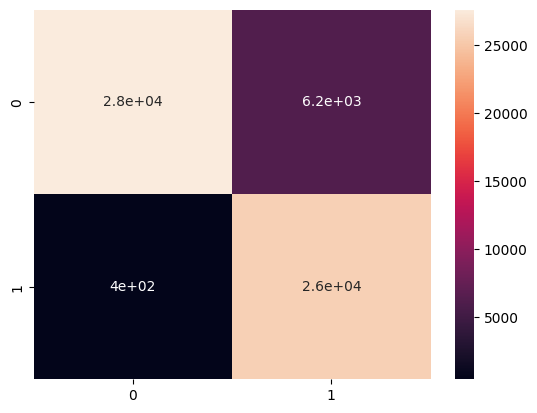

In [22]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.89     33882
         1.0       0.80      0.98      0.89     26118

    accuracy                           0.89     60000
   macro avg       0.90      0.90      0.89     60000
weighted avg       0.91      0.89      0.89     60000

